## A Nonconvex Example

We demonstrate a few different optimization algorithms on a robust regression problem using the Tukey's Bi-Weight loss (on a single data point $u = a_i^Tx-b$):
$$
f(u) = \begin{cases}
\frac{\theta^2}{6}\left(1 - \left(1 - \frac{u^2}{\theta^2}\right)^3\right) & \text{if } |u| \leq \theta \\
\frac{\theta^2}{6} & \text{otherwise}. 
\end{cases}
$$

For reference, see Appendix B.1 of ["Statistical consistency and asymptotic normality for high-dimensional robust 
M-estimators"](https://projecteuclid.org/journals/annals-of-statistics/volume-45/issue-2/Statistical-consistency-and-asymptotic-normality-for-high-dimensional-robust-M/10.1214/16-AOS1471.full).

The data is generated using the strategy outlined in Section 5 of ["“Convex Until Proven Guilty”: Dimension-Free Acceleration of Gradient Descent on Non-Convex Functions"](http://proceedings.mlr.press/v70/carmon17a/carmon17a.pdf).

First, we define the Tukey Bi-Weight function and its gradient.

In [52]:
function tukey( x, data, mode )
#F Calculate the function or gradient of Tukey's Biweight (from Po-Ling's paper)
#   data stores the data matrix A and rhs vector b
  param = sqrt(6)
  squared = param^2

  A = data[:A]
  b = data[:b]
  
  m = size(A,1);
  sum = 0;
  if(mode == 1)
  #function
    for i in 1:m
      θ = A[i,:]'*x - b[i]
      if(abs(θ) <= param)
        sum = sum + (squared/6)*(1 - (1 - θ^2/squared)^3)
      else
        sum = sum + (squared/6)
      end
    end
  else
  #gradient
    sum = zeros(d)
    for i in 1:m
      a = A[i,:]'
      θ = a*x - b[i]
      if(abs(θ) <= param)
        sum = sum .+ a'*θ*(1-θ^2/squared)^2
      end
    end
  end
  return sum./m 
end

tukey (generic function with 1 method)

Code to generate the data.

In [101]:
using Random, Distributions, LinearAlgebra

function generatedata( m, d )
#Generates the data given the number of samples m and the dimension of
#the problem d
    mu = zeros(d);
    sigma = I;

    dist = MvNormal(mu,sigma);

    A = zeros(m,d)
    for i in 1:m
        A[i,:] = rand(dist);
    end

    dist2 = MvNormal(mu,4*sigma);
    z = rand(dist2);

    dist3 = MvNormal(zeros(m), I)    
    v1 = rand(dist3);
    
    #IID Bernoulli(0.3)
    v2 = rand(m);
    v2 = (v2.>0.3);

    b = A*z + 3*v1 + v2;
    
    trueb = z;

    return (A, b, trueb)
end
    
    

generatedata (generic function with 1 method)

Gradient descent

In [84]:
function gd( fun, data, x0, eps, ls, c1, c2 )
    #GD Gradient descent implemenation
    k = 0;

    x = Dict()
    x[:p] = x0;
    
    #Start alpha at 1, will get doubled at start of linesearch
    alpha = 0.5;

    #Calculate the function and gradient
    x[:f] = fun(x[:p], data, 1);
    x[:g] = fun(x[:p], data, 2);
    fiters = 1;
    giters = 1;
        
    maxit = 10000
    grads = zeros(maxit)
    grads[1] = norm(x[:g])
    for i in 1:maxit
        #Search direction is the negative gradient direction
        d = -x[:g];
        #Starting step size
        alpha = max(alpha*2, 1);
        #Find step size using ls function. Calculates function and gradient
        #at xnew for use in next iteration
        (xnew,alpha,nf,ng) = ls(fun, data, x, d, alpha, c1, c2);
        x = xnew;
        
        fiters = fiters + nf;
        giters = giters + ng;
        grads[i+1] = norm(x[:g])
        
        if(norm(x[:g]) <= eps)
            #Found approx solution, exit loop
            k=i
            grads = grads[1:k+1]
            break
        end
    end
    return (x, k, fiters, giters, grads)
end



gd (generic function with 1 method)

Line search method for GD (EBLS).

In [56]:
function EBLS(fun, data, x, d, alpha_start, c1, c2)
#Line search to find step size
    maxit=1000;
    nf=0;ng=0;
    L=0; U=Inf; alpha=alpha_start;
    f=x[:f]; g=x[:g];
    for jj=1:maxit
        #New trial point xa
        xa=x[:p]+alpha*d;
        #Evaluate function at xa, increase number of function evaluations
        fa=fun(xa, data, 1); nf=nf+1;
        #Check if the function decreased enough
        if (fa>f+c1*alpha*g'*d)
            #Not enough decrease, update stepsize, go through loop
            U = alpha; alpha=(L+U)/2;
        else
            #Evaluate gradient at xa, increase number of gradient evals
            ga=fun(xa,data,2); ng=ng+1;
            #Check curvature condition
            if (ga'*d<c2*g'*d)
                #Not good, update step size and go through loop
                L = alpha;
                if (U==Inf)
                    alpha=2*L;
                else
                    alpha=(L+U)/2;
                end
            else
                #Decrease and curvature are satisfactory, exit function
                x[:p]=xa; x[:f]=fa; x[:g]=ga;
                break
            end
        end
    end
    return (x,alpha,nf,ng)
end

EBLS (generic function with 1 method)

Bool[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,

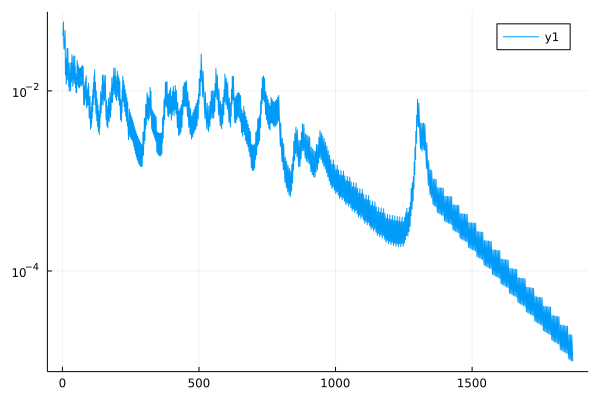

In [102]:
using Random, Distributions, LinearAlgebra, Plots

d = 100
m = 1000
n = d

(A, b, groundtruth) = generatedata(m, d)

func = tukey


data = Dict()
data[:A] = A
data[:b] = b

x0 = rand(MvNormal(zeros(n),I))
eps = 10^-5
c1 = 10^-3
c2 = 0.3
ls = EBLS

(xout, iters, fiters, giters, grads) = gd(func, data, x0, eps, ls, c1, c2)
println("GD completed after ", iters, " iterations using ", fiters, " function evaluations and ", giters, " gradient evaluations.")
;
plot(1:length(grads),grads, yaxis=:log)